# Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy wfdb matplotlib

In [2]:
import os
import configparser

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.io import savemat

import wfdb

from denoising import preprocess

In [3]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [4]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw/stdb-1.0.0')
FILTERED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/filtered/mecg/stdb-1.0.0')

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(FILTERED_DATA_DIR, exist_ok=True)

SIZE = 28
SAMPLING_RATE = 360

In [5]:
def get_filenames_stdb(data_dir : str = RAW_DATA_DIR) -> np.ndarray:
    # sampled at 250 Hz
    # data 1812903 x 2
    extra_files = ['ANNOTATORS', 'RECORDS', 'SHA256SUMS']
    fnames = [f for f in os.listdir(data_dir)]
    fnames_trunc = set(os.path.join(data_dir, fname.split('.')[0]) for fname in fnames)
    for f in extra_files:
        x = f'{data_dir}/{f}'
        if x in fnames_trunc:
            fnames_trunc.remove(x)
    
    return np.array(sorted(fnames_trunc), dtype=str)

In [6]:
filenames = get_filenames_stdb()

In [7]:
samp = wfdb.rdsamp(filenames[0])
samp

(array([[ 0.13513514, -0.01666667],
        [ 0.16554054, -0.00333333],
        [ 0.18581081, -0.01333333],
        ...,
        [-0.12837838,  0.01      ],
        [-0.12837838,  0.01666667],
        [-0.13175676,  0.01333333]]),
 {'fs': 360,
  'sig_len': 536976,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['ECG', 'ECG'],
  'comments': []})

In [8]:
samp[0].shape

(536976, 2)

In [9]:
def load_ecg_stdb(fname : str) -> np.ndarray:
    signal, _ = wfdb.rdsamp(fname)
    return signal[:,0]

# Filtering Analysis

Preprocessing pipeline consists of an FIR filter to eliminate powerline noise and baseline drift followed by Savitsky Golay for smoothing and a wavelet filter. Each filtering step is tested and selected added in each of the following sections.

In [10]:
preprocess_params = {}

## FIR Filter

In [11]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

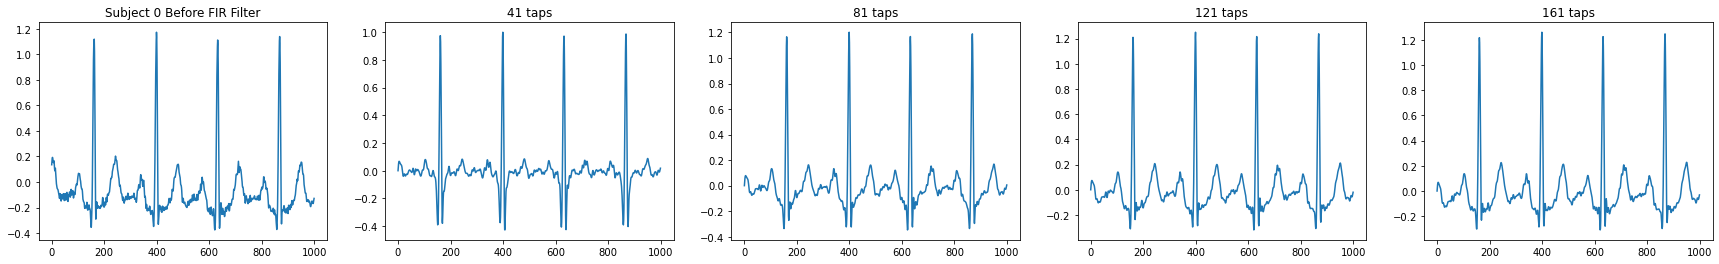

In [12]:
preprocess_params['numtaps'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor

taps_delta = 40
taps_start = 41

for i in range(subset_len):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_stdb(filenames[ind]), SAMPLING_RATE, **preprocess_params)
    
    axs[0].set_title(f'Subject {ind} Before FIR Filter')
    axs[0].plot(sig_window[:1000])
    
    for j in range(1, 5):
        taps = taps_delta * (j - 1) + taps_start
        preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, numtaps=taps)
        axs[j].set_title(f'{taps} taps')
        axs[j].plot(preprocessed_signal[:1000])

    plt.show()

In [13]:
preprocess_params['numtaps'] = 161

## Savitzky Golay Filter

In [14]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

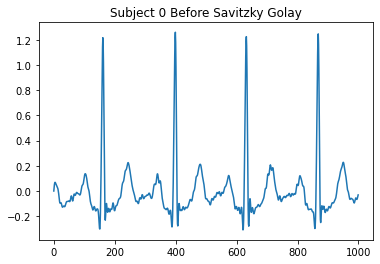

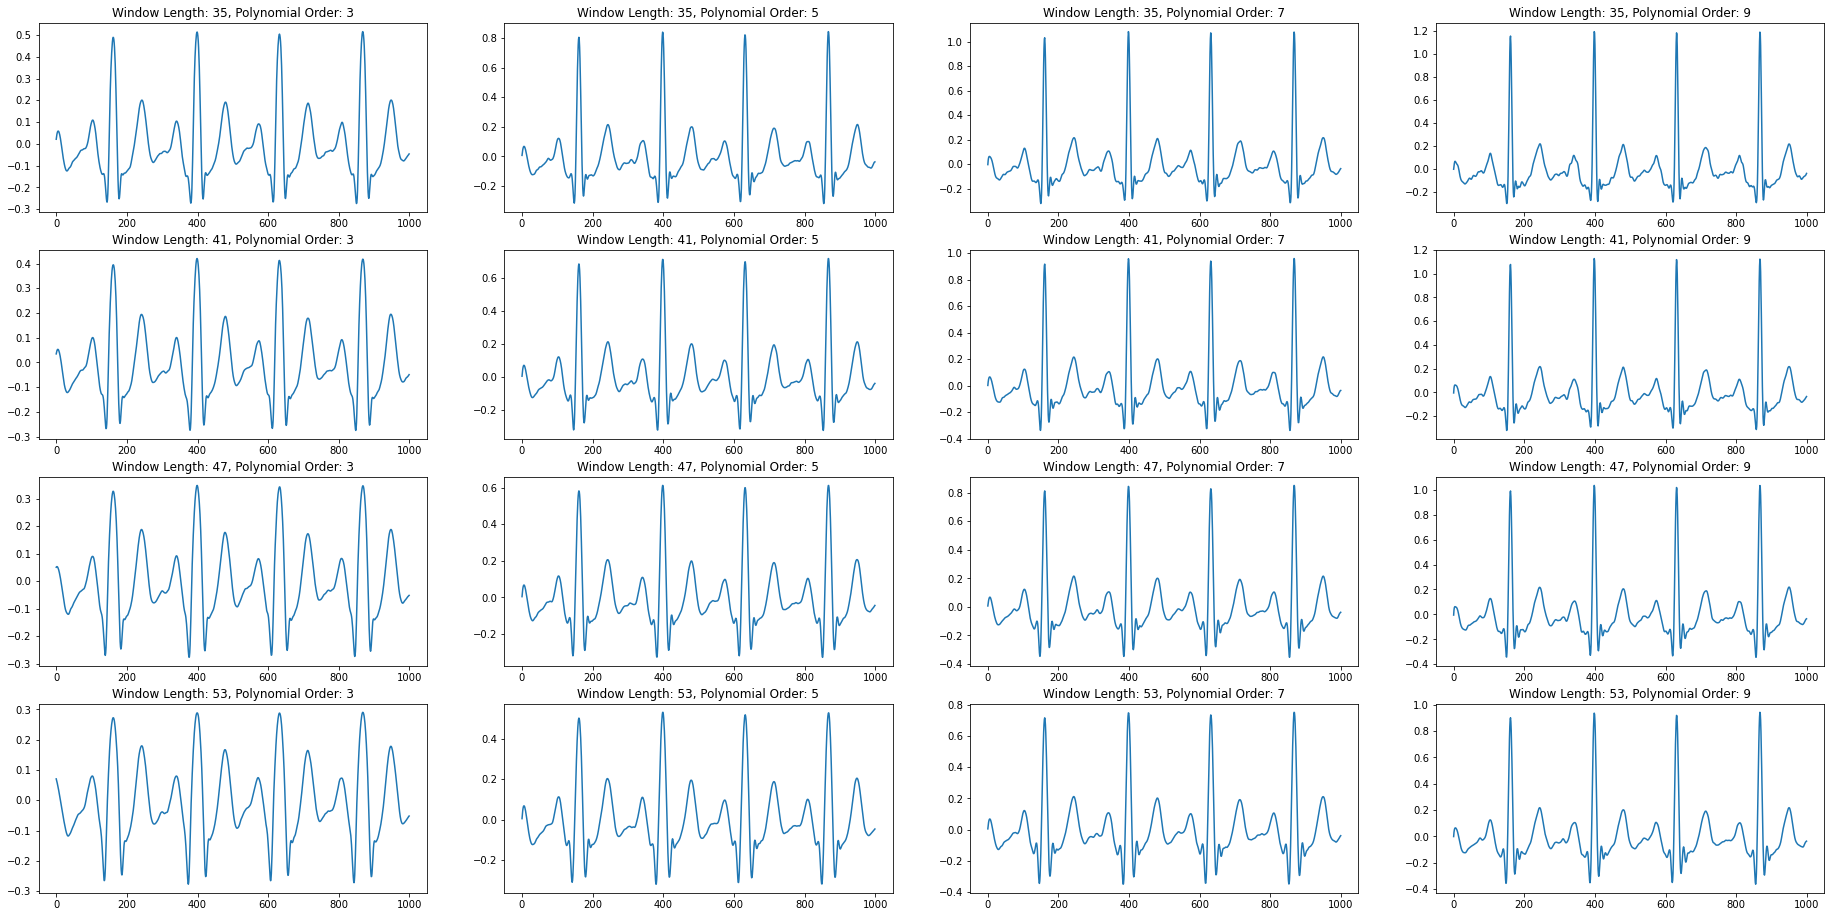

In [15]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor

win_cand = (35, 41, 47, 53)
ord_cand = (3, 5, 7, 9)
win_cand_count = len(win_cand)
ord_cand_count = len(ord_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_stdb(filenames[ind]), SAMPLING_RATE, **preprocess_params)

    plt.title(f'Subject {ind} Before Savitzky Golay')
    plt.plot(sig_window[:1000])

    fig, axs = plt.subplots(nrows=win_cand_count, ncols=ord_cand_count, figsize=(8 * win_cand_count, 4 * ord_cand_count))
    for j in range(win_cand_count):
        for k in range(ord_cand_count):
            winlen = win_cand[j]
            polyorder = ord_cand[k]
            preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, winlen=winlen, polyorder=polyorder)
            axs[j][k].set_title(f'Window Length: {winlen}, Polynomial Order: {polyorder}')
            axs[j][k].plot(preprocessed_signal[:1000])

    plt.show()

In [16]:
preprocess_params['winlen'] = 47
preprocess_params['polyorder'] = 7

## Wavelet Filter

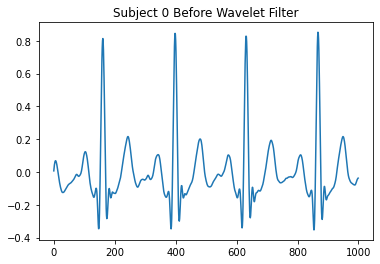

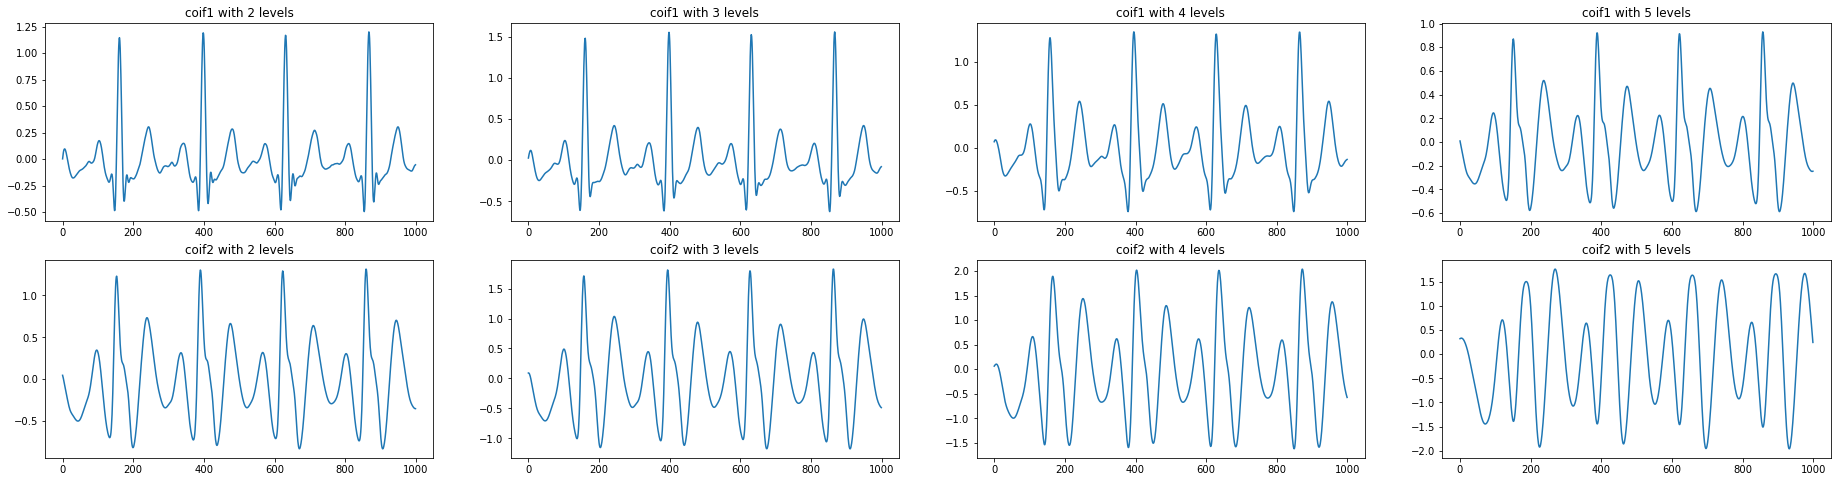

In [17]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor

family = 'coif'
wave_cand = (1, 2)
wave_cand_count = len(wave_cand)
levels_cand = (2, 3, 4, 5)
levels_cand_count = len(levels_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_stdb(filenames[ind]), SAMPLING_RATE, **preprocess_params)

    plt.title(f'Subject {ind} Before Wavelet Filter')
    plt.plot(sig_window[:1000])
    fig, axs = plt.subplots(nrows=wave_cand_count, ncols=levels_cand_count, figsize=(8 * levels_cand_count, 4 * wave_cand_count))
    for j in range(wave_cand_count):
        for k in range(levels_cand_count):
            wavelet = f'{family}{wave_cand[j]}'
            lvl = levels_cand[k]
            sig_window, _ = preprocess(sig_window, SAMPLING_RATE, wavelet=wavelet, lvl=lvl)
            axs[j][k].set_title(f'{wavelet} with {lvl} levels')
            axs[j][k].plot(sig_window[:1000])

    plt.show()

In [18]:
preprocess_params['wavelet'] = 'coif1'
preprocess_params['lvl'] = 4

# Filter All and Save

In [19]:
def save_data_stdb(filenames : np.ndarray, preprocess_params : dict, data_dir : str = FILTERED_DATA_DIR): 
    for fname in filenames:
        raw_sig = load_ecg_stdb(fname)
        filt_sig, light_filt_sig = preprocess(raw_sig, SAMPLING_RATE, **preprocess_params)
        d = {'filtered' : filt_sig, 'light': light_filt_sig, 'raw' : raw_sig}
        savemat(file_name=os.path.join(FILTERED_DATA_DIR, os.path.basename(fname)), mdict=d)

In [21]:
save_data_stdb(filenames, preprocess_params)